<a href="https://colab.research.google.com/github/cataltasz/LoginWinforms/blob/master/taxi_fare_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing necessary libraries and setting up the environment

#### Setup environment

In [1]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# connect to drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# change directory to kaggle folder. 
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/My Drive/Kaggle"
%cd /content/drive/My Drive/Kaggle

/content/drive/My Drive/Kaggle


#### Download Dataset

In [ ]:
# download dataset from kaggle
!kaggle competitions download -c new-york-city-taxi-fare-prediction

  0% 0.00/960k [00:00<?, ?B/s]
100% 960k/960k [00:00<00:00, 31.7MB/s]
  0% 0.00/486 [00:00<?, ?B/s]
100% 486/486 [00:00<00:00, 65.7kB/s]
  0% 0.00/335k [00:00<?, ?B/s]
100% 335k/335k [00:00<00:00, 43.1MB/s]
100% 1.55G/1.56G [00:21<00:00, 71.7MB/s]
100% 1.56G/1.56G [00:21<00:00, 77.1MB/s]


In [ ]:
# unzip train.csv
!unzip \*.zip  && rm *.zip

Archive:  train.csv.zip
  inflating: train.csv               


# Data Description and Initial Processing on Dataset

## Loading dataset to memory

In [4]:
# Load dataset using pandas
dataset = pd.read_csv('train.csv', nrows = 500_000, parse_dates = ['pickup_datetime'])

## Statistics and removal of outliers

In [5]:
# Show basic statistics of dataset
dataset.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,500000.000000,500000.000000,500000.000000,499995.000000,499995.000000,500000.000000
mean,11.358361,-72.519958,39.920276,-72.522435,39.916526,1.683428
std,9.916617,11.856831,8.073475,11.797362,7.391002,1.307395
min,-44.900000,-2986.242495,-3116.285383,-3383.296608,-2559.748913,0.000000
25%,6.000000,-73.992047,40.734917,-73.991382,40.734057,1.000000
50%,8.500000,-73.981785,40.752670,-73.980126,40.753152,1.000000
75%,12.500000,-73.967117,40.767076,-73.963572,40.768135,2.000000
max,500.000000,2140.601160,1703.092772,40.851027,404.616667,6.000000


In [6]:
# Show first 5 rows of dataset
dataset.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1


In [7]:
# will be used to restrict locations
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)

In [17]:
dataset = dataset.dropna(how = 'any', axis = 'rows')
dataset = dataset[((dataset['pickup_longitude'] > city_long_border[0]) & (dataset['pickup_longitude'] < city_long_border[1])) & 
                  ((dataset['dropoff_longitude'] > city_long_border[0]) & (dataset['dropoff_longitude'] < city_long_border[1])) & 
                  ((dataset['pickup_latitude'] > city_lat_border[0]) & (dataset['pickup_latitude'] < city_lat_border[1])) & 
                  ((dataset['dropoff_latitude'] > city_lat_border[0]) & (dataset['dropoff_latitude'] < city_lat_border[1])) & 
                  (dataset['passenger_count'] > 0) & 
                  ((dataset['fare_amount'] >= 2.5) & (dataset['fare_amount'] < 100))]

In [20]:
dataset.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,weekday,hour
count,481292.000000,481292.000000,481292.000000,481292.000000,481292.000000,481292.000000,481292.000000,481292.000000,481292.000000,481292.000000,481292.000000
mean,10.999539,-73.975651,40.750907,-73.974536,40.751177,1.689698,2011.739512,6.270962,15.678017,3.040701,13.524104
std,8.721191,0.033539,0.026220,0.032005,0.028447,1.305867,1.865927,3.439643,8.680864,1.948343,6.490928
min,2.500000,-74.029745,40.630097,-74.029902,40.630057,1.000000,2009.000000,1.000000,1.000000,0.000000,0.000000
25%,6.000000,-73.992249,40.736657,-73.991520,40.735948,1.000000,2010.000000,3.000000,8.000000,1.000000,9.000000
50%,8.500000,-73.982090,40.753390,-73.980659,40.753880,1.000000,2012.000000,6.000000,16.000000,3.000000,14.000000
75%,12.500000,-73.968471,40.767402,-73.965785,40.768250,2.000000,2013.000000,9.000000,23.000000,5.000000,19.000000
max,99.500000,-73.750322,40.849922,-73.750061,40.849988,6.000000,2015.000000,12.000000,31.000000,6.000000,23.000000


In [18]:
# create new fields based on pickup_datetime that will help our model. 
dataset['year'] = dataset.pickup_datetime.dt.year
dataset['month'] = dataset.pickup_datetime.dt.month
dataset['day'] = dataset.pickup_datetime.dt.day
dataset['weekday'] = dataset.pickup_datetime.dt.weekday
dataset['hour'] = dataset.pickup_datetime.dt.hour

## Visualizations

#### Fare amount

Text(0.5, 1.0, 'Distribution of fare amount (log scale)')

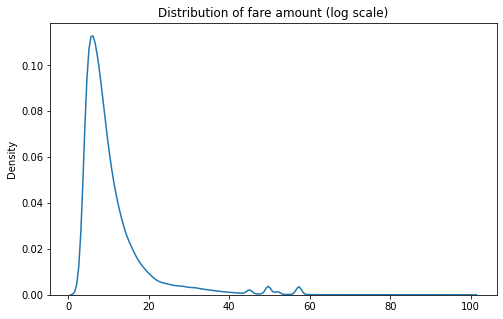

In [19]:
plt.figure(figsize=(8,5))
sns.kdeplot(dataset['fare_amount'].values).set_title("Distribution of fare amount")

In [15]:
d = dataset[["fare_amount"]]
len(d[d["fare_amount"] > 100])

28

#### Locations

In [16]:
def plot_loc_heat_map(kind, color):
  dataset.plot(kind='scatter', x=kind.lower() +'_longitude', y=kind.lower()+'_latitude',
                  color=color, 
                  s=.02, alpha=.6)
  plt.title(kind + " Locations")

  plt.ylim(city_lat_border)
  plt.xlim(city_long_border)

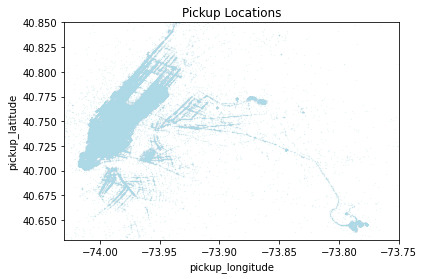

In [17]:
plot_loc_heat_map("Pickup", "lightblue")

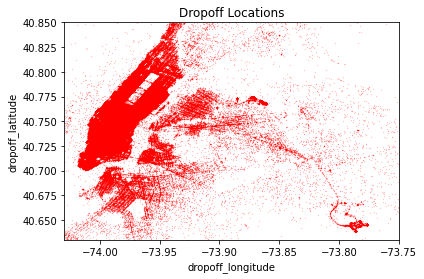

In [18]:
plot_loc_heat_map("Dropoff", "red")

#### Passenger count

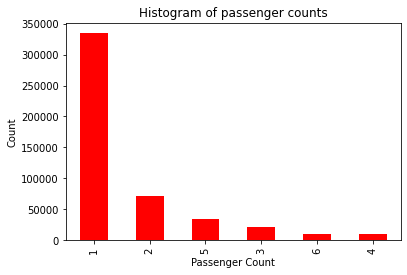

In [20]:
dataset['passenger_count'].value_counts().plot.bar(color='red');
plt.title('Histogram of passenger counts'); plt.xlabel('Passenger Count'); plt.ylabel('Count');

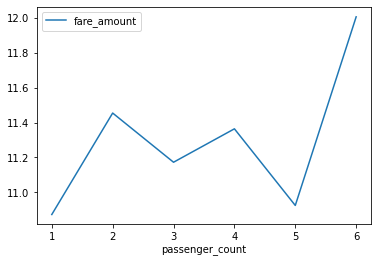

In [41]:
dataset[['passenger_count', 'fare_amount']].groupby('passenger_count').mean().plot()

#### Visualizations on date of taxi ride

##### Year

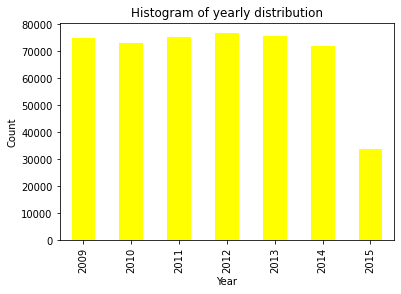

In [36]:
dataset['year'].value_counts().sort_index().plot.bar(color='yellow');
plt.title('Histogram of yearly distribution'); plt.xlabel('Year'); plt.ylabel('Count');

##### Weekday

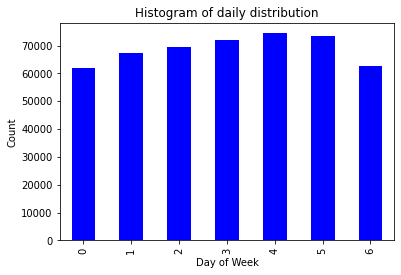

In [38]:
dataset['weekday'].value_counts().sort_index().plot.bar(color='blue');
plt.title('Histogram of daily distribution'); plt.xlabel('Day of Week'); plt.ylabel('Count');

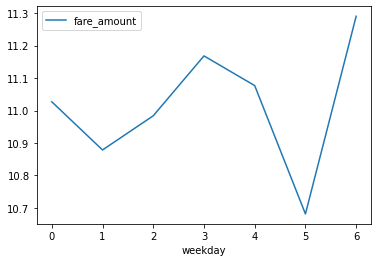

In [39]:
mean_data = dataset[['weekday', 'fare_amount']].groupby('weekday').mean().plot()

##### Hours of day

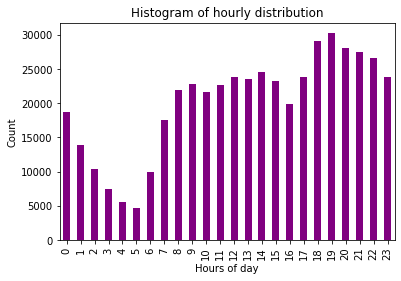

In [37]:
dataset['hour'].value_counts().sort_index().plot.bar(color='purple');
plt.title('Histogram of hourly distribution'); plt.xlabel('Hours of day'); plt.ylabel('Count');

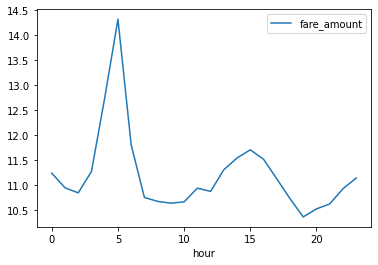

In [40]:
mean_data = dataset[['hour', 'fare_amount']].groupby('hour').mean().plot()